In [5]:
%load_ext autoreload
%autoreload 2

import os, sys
from pathlib import Path
import yaml
import torch

from matplotlib import pyplot as plt

# sys.path.append(os.path.abspath(".."))

# from rade_gs.models import RadegsModel, RadegsModelConfig
from nerfstudio.models.splatfacto import SplatfactoModel, SplatfactoModelConfig
from nerfstudio.utils.eval_utils import eval_setup
from nerfstudio.data.scene_box import OrientedBox, SceneBox

from ns_extension.datamanagers.features_datamanager import FeatureSplattingDataManagerConfig, FeatureSplattingDataManager
from ns_extension.models.rade_gs_model import RadegsModelConfig, RadegsModel
from ns_extension.models.rade_features_model import RadegsFeaturesModelConfig, RadegsFeaturesModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load configuration

In [21]:
# Find config for our current model
load_config = Path('/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/feature-splatting/2025-07-03_022235/config.yml')

config = yaml.load(load_config.read_text(), Loader=yaml.Loader)

In [22]:
config.pipeline.datamanager.segmentation_backend = "mobilesamv2"
config.pipeline.datamanager.segmentation_strategy = "object"
config.pipeline.datamanager.obj_resolution = 100
config.pipeline.datamanager.final_resolution = 64
# config.pipeline.datamanager.feature_type = "CLIP"
config.pipeline.datamanager.enable_cache = True
config.pipeline.datamanager.sam_resolution = 1024

config.pipeline.datamanager.main_features = "samclip"
config.pipeline.datamanager.regularization_features = "dinov2"

# datamanager = FeatureSplattingDataManager(config.pipeline.datamanager)

In [23]:
config.pipeline.datamanager.main_features

'samclip'

In [25]:
datamanager = FeatureSplattingDataManager(config.pipeline.datamanager)

[20:18:15] Auto image downscale factor of 2                                                 ]8;id=312952;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=920363;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\

KeyboardInterrupt: 

In [10]:
datamanager.train_features['dinov2'].shape

torch.Size([441, 384, 57, 32])

### Load feature splatting pipe

In [11]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# pipeline = config.pipeline.setup(device='cuda', test_mode='inference')

aabb_scale = datamanager.dataparser.config.scene_scale

scene_box = SceneBox(
    aabb=torch.tensor(
        [[-aabb_scale, -aabb_scale, -aabb_scale], [aabb_scale, aabb_scale, aabb_scale]], dtype=torch.float32
    )
)

train_samples = len(datamanager.train_dataset)

In [15]:
datamanager.train_dataset.metadata

{'depth_filenames': None,
 'depth_unit_scale_factor': 0.001,
 'mask_color': None,
 'points3D_xyz': tensor([[ 0.5881,  0.2354,  0.3443],
         [ 0.5153,  0.2859,  0.1964],
         [ 0.5296,  0.2778,  0.2392],
         ...,
         [ 0.4155,  0.4354,  0.4631],
         [-0.0926,  0.2761,  0.3994],
         [ 0.4062,  0.4324,  0.4728]]),
 'points3D_rgb': tensor([[174, 173, 178],
         [ 20,  10,   6],
         [104,  97,  96],
         ...,
         [ 77,  81,  59],
         [ 52,  54,  45],
         [ 41,  50,  32]], dtype=torch.uint8),
 'feature_type': 'SAMCLIP',
 'feature_dims': {'dinov2': torch.Size([384, 57, 32]),
  'samclip': torch.Size([768, 113, 64])}}

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = RadegsFeaturesModelConfig(output_depth_during_training=False)
config.sh_degree = 0

radegs_model = RadegsFeaturesModel(
    config, 
    scene_box=scene_box, 
    num_train_data=train_samples,
    metadata=datamanager.train_dataset.metadata,
)
radegs_model.populate_modules()

radegs_model = radegs_model.to(device)

radegs_model.eval()

# radegs_model.get_outputs(camera)

KeyError: 'SAMCLIP'

In [83]:
radegs_model.gauss_params['distill_features']

AttributeError: 'ParameterDict' object has no attribute 'distill_features'

In [60]:
idx = 0
camera = datamanager.train_dataset.cameras[idx:idx+1].to(device)

In [61]:
outputs = radegs_model.get_outputs(camera)

/tmp/ns-extension/ns_extension/utils/camera_utils.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(get_world2view_transform(R, T, trans, scale)).transpose(0, 1).cuda()


In [28]:
from nerfstudio.models.splatfacto import num_sh_bases

In [70]:
datamanager.train_dataset.metadata

{'depth_filenames': None,
 'depth_unit_scale_factor': 0.001,
 'mask_color': None,
 'points3D_xyz': tensor([[ 0.5881,  0.2354,  0.3443],
         [ 0.5153,  0.2859,  0.1964],
         [ 0.5296,  0.2778,  0.2392],
         ...,
         [ 0.4155,  0.4354,  0.4631],
         [-0.0926,  0.2761,  0.3994],
         [ 0.4062,  0.4324,  0.4728]]),
 'points3D_rgb': tensor([[174, 173, 178],
         [ 20,  10,   6],
         [104,  97,  96],
         ...,
         [ 77,  81,  59],
         [ 52,  54,  45],
         [ 41,  50,  32]], dtype=torch.uint8),
 'feature_type': 'SAMCLIP',
 'feature_dims': {'dinov2': torch.Size([384, 57, 32]),
  'samclip': torch.Size([768, 113, 64])}}

In [62]:
features_dc_crop = radegs_model.features_dc
features_rest_crop = radegs_model.features_rest

colors_crop = torch.cat((features_dc_crop[:, None, :], features_rest_crop), dim=1)

colors_crop.shape

torch.Size([50000, 16, 3])

In [15]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version PyTorch was compiled with: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

PyTorch version: 2.1.2+cu118
CUDA available: True
CUDA version PyTorch was compiled with: 11.8
Number of GPUs: 1


In [16]:
# Before calling radegs_model.get_outputs(camera)
print(f"Camera device: {camera.device if hasattr(camera, 'device') else 'No device attr'}")

# Check model parameters
for name, param in radegs_model.named_parameters():
    if param.device.type != 'cuda':
        print(f"Parameter {name} is on {param.device}")
        break

Camera device: cpu
Parameter device_indicator_param is on cpu


In [111]:
# Move the entire model to CUDA
radegs_model = radegs_model.cuda()

# Or if you want to be explicit about the device
device = torch.device('cuda:0')
radegs_model = radegs_model.to(device)

camera = camera.to('cuda:0')

In [112]:
outputs = radegs_model.get_outputs(camera)

/tmp/rade_gs/rade_gs/utils/camera_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1).cuda()


In [19]:
fs_outputs = pipeline.model.get_outputs(camera)

/opt/conda/envs/nerfstudio/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


### Load Radegs pipe

In [28]:
# Find config for our current model
rade_gs_load_config = Path('/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-gs/2025-07-02_114948/config.yml')

rade_gs_config = yaml.load(rade_gs_load_config.read_text(), Loader=yaml.Loader)

# Create the environment
rade_gs_pipeline = rade_gs_config.pipeline.setup(device='cuda', test_mode='inference')

In [32]:
radegs_outs = rade_gs_pipeline.model.get_outputs(camera)

In [ ]:
pipeline.model.get_outputs()

In [38]:
camera.get_intrinsics_matrices().shape

torch.Size([1, 3, 3])

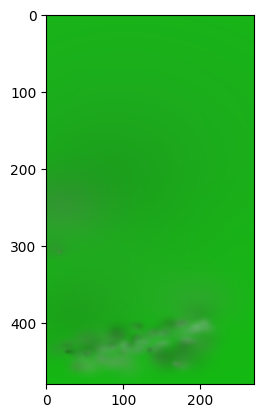

In [34]:
radegs_im = radegs_outs['rgb'].detach().cpu().numpy()
plt.imshow(radegs_im)
plt.show()